# Gurobi Practice - Summer Week 1

There are three sections to this file:

- Gurobi Tutorials

- 6.720 Recitations

- JuMP Tutorials

# Gurobi Tutorials

The goal of this is to warm up and train coding skills in Gurobi. This will be based on several Gurobi tutorials.

Many of these steps are fundamental to solving the column generation in the UROP. For me, this was essential and necessary, and I have successfully gotten over some humps that I couldn't in the spring.

In [2]:
using LinearAlgebra, Random, Gurobi, JuMP, Distributions, LazySets

## Linear Programming: Gurobi Tutorial

### Writing the Model
A short model for furniture in the Gurobi series on Linear Programming.

In [21]:
furniture = Model(Gurobi.Optimizer);

@variable(furniture, x1, base_name = "chairs") # chairs
@variable(furniture, x2, base_name = "tables") # tables

@objective(furniture, Max, 45*x1+80*x2)

@constraint(furniture, 5*x1+20*x2 <= 400, base_name = "wood_constraint")
@constraint(furniture, 10*x1 + 15*x2 <= 450, base_name = "labor_constraint")

#well these trivial constraints have to be set
@constraint(furniture, x1 >= 0, base_name = "non-negative chairs")
@constraint(furniture, x2 >= 0, base_name = "non-negative tables")


optimize!(furniture)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4 rows, 2 columns and 6 nonzeros
Model fingerprint: 0x73c67f7c
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [4e+01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+02, 4e+02]
Presolve removed 2 rows and 0 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.6000000e+03   5.682900e+01   0.000000e+00      0s
       2    2.2000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.200000000e+03

User-callback calls 41, time in user-callback 0.00 sec


Matrix range represents smallest and largest coefficients in the A of Ax <= b.

Objective range represents smallest and largest coefficients in the c of max cx.

Bounds range represents smallest and largest values of the x.

RHS range tells us the smallest and largest coefficients in the b of Ax <= b.

### Property Extraction from Model
This took a surprisingly long time and relied on multiple searches on JuMP documentation, Stack Overflow, and video tutorials. It appears the Python version of Gurobi, gurobipy, is more straightforward for calculating these properties. Looks like I just needed to sit down and code for a whole day.

This was also one of the things I tried to do in the spring, but failed. Now I have worked it out successfully.

In [4]:
using JuMP
using MathOptInterface

#=
VARIABLES.
https://jump.dev/JuMP.jl/v0.20.0/variables/index.html#Variables-1
=#
#variable_by_name found in StackOverflow

chairs = variable_by_name(furniture, "chairs")
print(value.(chairs), " Chairs\n")
tables = variable_by_name(furniture, "tables")
print(value.(tables), " Tables\n")

print("All variables of the furniture model: ", all_variables(furniture), "\n")

#=
CONSTRAINTS.
https://jump.dev/JuMP.jl/stable/manual/constraints/
=#
wood = constraint_by_name(furniture, "wood_constraint")
print(wood, "\n")
labor = constraint_by_name(furniture, "labor_constraint")
print(labor, "\n")

#=
The reason including and excluding are exactly the same is because
the 'implicit' constraints >= 0 were explicitly laid out.
Had I used e.g. Int variables instead, then there would be a difference
between the including and excluding cases because then the >= 0 
is in "including" but not "excluding"
=#
print("All constraints of the furniture model, INCLUDING individual variable constraints:\n ", all_constraints(furniture; include_variable_in_set_constraints = true), "\n")
print("All constraints of the furniture model, EXCLUDING individual variable constraints:\n ", all_constraints(furniture; include_variable_in_set_constraints = false), "\n")

24.0 Chairs
14.0 Tables
All variables of the furniture model: VariableRef[chairs, tables]
wood_constraint : 5 chairs + 20 tables ≤ 400.0
labor_constraint : 10 chairs + 15 tables ≤ 450.0
All constraints of the furniture model, INCLUDING individual variable constraints:
 ConstraintRef[non-negative chairs : chairs ≥ 0.0, non-negative tables : tables ≥ 0.0, wood_constraint : 5 chairs + 20 tables ≤ 400.0, labor_constraint : 10 chairs + 15 tables ≤ 450.0]
All constraints of the furniture model, EXCLUDING individual variable constraints:
 ConstraintRef[non-negative chairs : chairs ≥ 0.0, non-negative tables : tables ≥ 0.0, wood_constraint : 5 chairs + 20 tables ≤ 400.0, labor_constraint : 10 chairs + 15 tables ≤ 450.0]


Here's an example of an integer variable whose integer requirement shows up in inclusive but not exclusive individual variable constraints.

In [5]:
@variable(furniture, trial_var, Int, base_name = "integer_trial")

print("All constraints of the furniture model, INCLUDING individual variable constraints:\n ", all_constraints(furniture; include_variable_in_set_constraints = true), "\n")
print("All constraints of the furniture model, EXCLUDING individual variable constraints:\n ", all_constraints(furniture; include_variable_in_set_constraints = false), "\n")

All constraints of the furniture model, INCLUDING individual variable constraints:
 ConstraintRef[non-negative chairs : chairs ≥ 0.0, non-negative tables : tables ≥ 0.0, wood_constraint : 5 chairs + 20 tables ≤ 400.0, labor_constraint : 10 chairs + 15 tables ≤ 450.0, integer_trial integer]
All constraints of the furniture model, EXCLUDING individual variable constraints:
 ConstraintRef[non-negative chairs : chairs ≥ 0.0, non-negative tables : tables ≥ 0.0, wood_constraint : 5 chairs + 20 tables ≤ 400.0, labor_constraint : 10 chairs + 15 tables ≤ 450.0]


Now, we can practice with the all variables.

In [6]:
all_furniture_vars = all_variables(furniture)

optimize!(furniture)

for var in all_furniture_vars
    print(var, " ")
    print(value.(var), "\n")
end

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4 rows, 3 columns and 6 nonzeros
Model fingerprint: 0x9c9d8adc
Variable types: 2 continuous, 1 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [4e+01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+02, 4e+02]
Found heuristic solution: objective 2025.0000000
Presolve removed 2 rows and 1 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros
Variable types: 2 continuous, 0 integer (0 binary)

Root relaxation: objective 2.200000e+03, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    2200.0000000 2200.00000  0.00%     -    0s

Explored 1 nodes (2 simplex iterations) in 0.01 secon

Results are as expected.

The Gurobi tutorial, which is written in gurobipy, uses a multidict function with products and resources as keys and their numbers as values.

In [23]:
#final step
print(objective_value(furniture))

2200.0

### Shadow Prices

<b>We will fix this at the end of this notebook!</b>

In [103]:
wood
# Example: get the dual of the wood constraint

shadow_price.(wood)
#no dual! because we shouldn't have used integer_trial

LoadError: The shadow price is not available because no dual result is available.

The Gurobi tutorials on linear programming also included a way to use a multidict to have multiple constraints be written instead as a matrix. I have not done this in this python notebook because we will not be using this.

## Mixed Integer Programming: Gurobi Tutorial

It ended up being too similar to class tutorials so I decided to skip this.

## Column Generation: Gurobi Tutorial

It ended up being in Python and a bit too dissimilar to our project. I'll do the 15.083hw5 next week instead.

# 6.720 Recitations, Adapted

Experiments on things I found helpful.

## from recitation 1

In [25]:
JuMP.latex_formulation(furniture)

$$ \begin{aligned}
\max\quad & 45 chairs + 80 tables\\
\text{Subject to} \quad & chairs \geq 0.0\\
 & tables \geq 0.0\\
 & 5 chairs + 20 tables \leq 400.0\\
 & 10 chairs + 15 tables \leq 450.0\\
\end{aligned} $$

LaTeX typing:

\begin{align}
    \begin{split}
        \min_{x, z} \quad & cx + z\\
        \text{s.t.} \quad & Ax \geq b \\
        & 1 - dx \leq z \\
        & 0 \leq z \\
        & 2dx-4 \leq z\\
    \end{split}
\end{align}

In [26]:
A = [1 0 0; 0 1 0; 0 0 1]

3×3 Matrix{Int64}:
 1  0  0
 0  1  0
 0  0  1

In [28]:
c = ones(3)
d = -ones(3)
b = zeros(3)

@show c
@show d
@show b

c = [1.0, 1.0, 1.0]
d = [-1.0, -1.0, -1.0]
b = [0.0, 0.0, 0.0]


3-element Vector{Float64}:
 0.0
 0.0
 0.0

In [45]:
using Gurobi, JuMP

sample_model = Model(Gurobi.Optimizer)
set_optimizer_attribute(sample_model, "TimeLimit", 70)

@variable(sample_model, z >= 0)
@variable(sample_model, x[1:3]) #array of 3 elements

@constraint(sample_model, A*x .>= b, base_name = "Ax >= b")
@constraint(sample_model, 1 - d' * x <= z)
@constraint(sample_model, 2 * d' * x - 4 <= z)

@objective(sample_model, Min, c' * x + z)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter TimeLimit to value 70


x[1] + x[2] + x[3] + z

In [46]:
JuMP.latex_formulation(sample_model)

$$ \begin{aligned}
\min\quad & x_{1} + x_{2} + x_{3} + z\\
\text{Subject to} \quad & x_{1} \geq 0.0\\
 & x_{2} \geq 0.0\\
 & x_{3} \geq 0.0\\
 & -z + x_{1} + x_{2} + x_{3} \leq -1.0\\
 & -z - 2 x_{1} - 2 x_{2} - 2 x_{3} \leq 4.0\\
 & z \geq 0.0\\
\end{aligned} $$

In [47]:
optimize!(sample_model)

Set parameter TimeLimit to value 70
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5 rows, 4 columns and 11 nonzeros
Model fingerprint: 0x83841d95
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 5 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.000000000e+00

User-callback calls 29, time in user-callback 0.00 sec


obtain information from the model

In [48]:
constraints = all_constraints(sample_model, include_variable_in_set_constraints = true)
print(constraints)
#=
The following code will throw an error because there are multiple constraints nested
under the array for "Ax >= b":
constraint_by_name(sample_model, "Ax >= b")

Rather than store constraints with an array, for instance, they all throw errors.
=#

ConstraintRef[Ax >= b : x[1] ≥ 0.0, Ax >= b : x[2] ≥ 0.0, Ax >= b : x[3] ≥ 0.0, -z + x[1] + x[2] + x[3] ≤ -1.0, -z - 2 x[1] - 2 x[2] - 2 x[3] ≤ 4.0, z ≥ 0.0]

In [49]:
# can nab values with value. for the x variable
print("Values of decision variables x1, x2, x3: ", value.(x))

Values of decision variables x1, x2, x3: [0.0, 0.0, 0.0]

In [50]:
#optimal value is objective_value
print("Optimal objective is: ", objective_value(sample_model))

Optimal objective is: 1.0

## from recitation 2

This one contains some plotting, as well as data creation, both of which are important in the UROP.

This is a pricing problem. We have a store and are modeling as follows:

- b is how much inventory you have before the time starts.
- e is how much inventory you have after the time has ended.
- c is how much cost you have for buying an item.
- h is the holding cost: if it's in the inventory, it's going to cost you.
- x is how much you BUY, but not necessarily how much you sell.
- D represents the demand matrix
- C represents the amount that you can buy at a certain time

\begin{align}
    \begin{split}
        \min \quad & \sum_t c[t]x[t] + 0.5h[t](b[t]+e[t])\\
        \text{s.t.} \quad & b[1] = 0 \\
        & e[t] = b[t] + x[t] - D[t] \ \forall t \\
        & b[t] = e[t-1] \ \forall t \geq 2 \\
        & x[t] \leq C[t] \ \forall t\\
    \end{split}
\end{align}

In [56]:
T = 5 # similar to number of vehicles in UROP

avg_avail = rand(Gamma(200, 250))
C = ones(T) * 400
avg_demand = rand(Gamma(4, 50))
D = rand(Gamma(2, avg_demand/2), T)
c = rand(Gamma(5, 15), T)
h = rand(Gamma(2, 5), T)

5-element Vector{Float64}:
 13.878938195607018
  7.524942481260939
 10.54858476661316
  3.3960825484094337
 11.202076814115623

In [57]:
buy = Model(Gurobi.Optimizer)

@variable(buy, x[1:T] >= 0)
@variable(buy, b[1:T] >= 0)
@variable(buy, e[1:T] >= 0)

@constraint(buy, b[1] == 0)
@constraint(buy, [t=1:T], e[t] == b[t] + x[t] - D[t])
@constraint(buy, [t=2:T], b[t] == e[t-1])
@constraint(buy, [t=1:T], x[t] <= C[t])

@objective(buy, Min, sum(c[t]*x[t] + 0.5 * h[t] * (b[t] + e[t]) for t=1:T))

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04


58.71692939650092 x[1] + 6.939469097803509 b[1] + 6.939469097803509 e[1] + 73.43654467486601 x[2] + 3.7624712406304694 b[2] + 3.7624712406304694 e[2] + 53.80355397999247 x[3] + 5.27429238330658 b[3] + 5.27429238330658 e[3] + 182.19840181738073 x[4] + 1.6980412742047168 b[4] + 1.6980412742047168 e[4] + 47.81340339581279 x[5] + 5.601038407057811 b[5] + 5.601038407057811 e[5]

In [58]:
JuMP.latex_formulation(buy)

$$ \begin{aligned}
\min\quad & 58.71692939650092 x_{1} + 6.939469097803509 b_{1} + 6.939469097803509 e_{1} + 73.43654467486601 x_{2} + 3.7624712406304694 b_{2} + 3.7624712406304694 e_{2} + 53.80355397999247 x_{3} + 5.27429238330658 b_{3} + 5.27429238330658 e_{3} + 182.19840181738073 x_{4} + 1.6980412742047168 b_{4} + 1.6980412742047168 e_{4} + 47.81340339581279 x_{5} + 5.601038407057811 b_{5} + 5.601038407057811 e_{5}\\
\text{Subject to} \quad & b_{1} = 0.0\\
 & -x_{1} - b_{1} + e_{1} = -273.07983972948495\\
 & -x_{2} - b_{2} + e_{2} = -246.5459836740374\\
 & -x_{3} - b_{3} + e_{3} = -58.57436119543125\\
 & -x_{4} - b_{4} + e_{4} = -455.1925639844843\\
 & -x_{5} - b_{5} + e_{5} = -103.47208404190623\\
 & b_{2} - e_{1} = 0.0\\
 & b_{3} - e_{2} = 0.0\\
 & b_{4} - e_{3} = 0.0\\
 & b_{5} - e_{4} = 0.0\\
 & x_{1} \leq 400.0\\
 & x_{2} \leq 400.0\\
 & x_{3} \leq 400.0\\
 & x_{4} \leq 400.0\\
 & x_{5} \leq 400.0\\
 & x_{1} \geq 0.0\\
 & x_{2} \geq 0.0\\
 & x_{3} \geq 0.0\\
 & x_{4} \geq 0.0\\

In [59]:
optimize!(buy)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 15 rows, 15 columns and 29 nonzeros
Model fingerprint: 0x56805ed3
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+01, 5e+02]
Presolve removed 12 rows and 8 columns
Presolve time: 0.00s
Presolved: 3 rows, 7 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.6794867e+04   7.716995e+01   0.000000e+00      0s
       4    7.2655234e+04   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.00 seconds (0.00 work units)
Optimal objective  7.265523408e+04

User-callback calls 75, time in user-callback 0.00 sec


In [60]:
# now, obtain the values associated with how much we buy

opt_x = value.(x)

5-element Vector{Float64}:
 400.0
 233.39274858343794
 400.0
   0.0
 103.47208404190623

In [61]:
opt_b = value.(b)

5-element Vector{Float64}:
   0.0
 126.92016027051505
 113.76692517991557
 455.1925639844843
   0.0

We can do a plot for these results

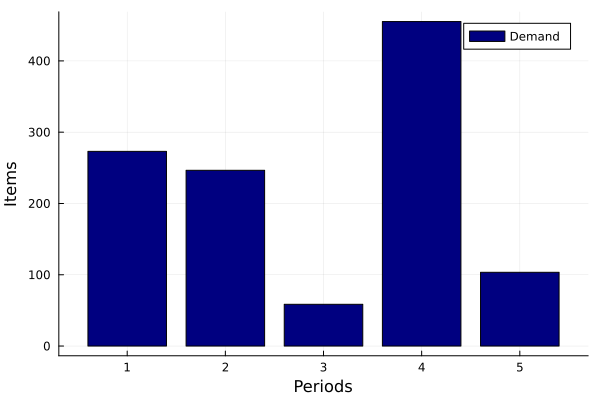

In [68]:
using Plots
bar(D, label = "Demand", xlabel = "Periods", ylabel = "Items", color = :navy)

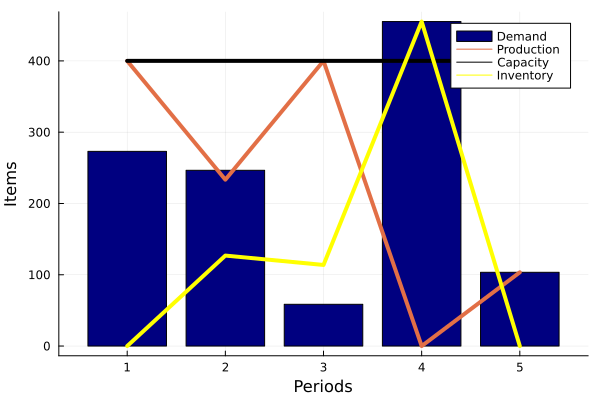

In [69]:
plot!(opt_x, label = "Production", xlabel = "Periods", ylabel = "Items", linewidth = 4)
plot!(C, label = "Capacity", xlabel = "Periods", ylabel = "Items", color = :black, linewidth = 4)
plot!(opt_b, label = "Inventory", xlabel = "Periods", ylabel = "Items", color = :yellow, linewidth = 4)

I also consulted recitations 4 and 9, but did not experiment with the code.

# JuMP Tutorials

This is practice I did to familiarize myself with JuMP, which was a problem in the spring. These have been tinkered with from the tutorials page, jump.dev/JuMP.jl/stable/tutorials.

## Facility Location

This one is similar to the UROP and also has similar graphing components.

In [72]:
using JuMP

import HiGHS, LinearAlgebra, Plots, Random

In [84]:
# build up initial data: clients, facilities, fixed costs, and distance between clients and facilities

Random.seed!(314)
clients = 12
facilities = 5

cx, cy = rand(clients) , rand(clients) # two-dimensional coordinates

fx, fy = rand(facilities), rand(facilities) # two-dimensional coordinates

fixed_costs = ones(facilities)

#compute distance function
distances = zeros(clients, facilities)

for i in 1:clients
    for j in 1:facilities
        distances[i, j] = LinearAlgebra.norm([cx[i] - fx[j], cy[i] - fy[j]], 2)
    end
end

LoadError: MethodError: no method matching round(::Vector{Float64}; digits=2)
[0mClosest candidates are:
[0m  round([91m::Union{Float16, Float32, Float64}[39m, [91m::RoundingMode{:ToZero}[39m) at float.jl:367[91m got unsupported keyword argument "digits"[39m
[0m  round([91m::Union{Float16, Float32, Float64}[39m, [91m::RoundingMode{:Down}[39m) at float.jl:368[91m got unsupported keyword argument "digits"[39m
[0m  round([91m::Union{Float16, Float32, Float64}[39m, [91m::RoundingMode{:Up}[39m) at float.jl:369[91m got unsupported keyword argument "digits"[39m
[0m  ...

### Plotting Data

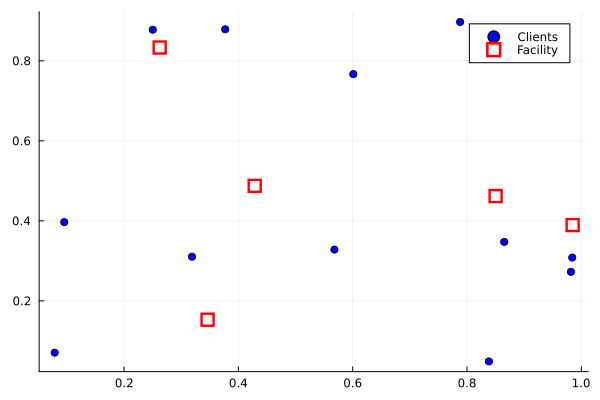

In [77]:
# display data
Plots.scatter(cx, cy; label = "Clients", markershape = :circle, markercolor = :blue)
Plots.scatter!(fx, fy; label = "Facility", markershape = :square, markercolor = :white, 
    markersize = 6, markerstrokecolor = :red, markerstrokewidth = 3)

Now we can build the model with the constraints: each client gets one facility; facilities that serve clients must be open 
(this is represented with x[client_number, facility_number] <= y[facility_number])

In [81]:
model = Model(HiGHS.Optimizer)
@variable(model, serve[1:clients, 1:facilities], Bin, base_name = "Serving Decision")
@variable(model, fac_open[1:facilities], Bin, base_name = "Open Facility")

@constraint(model, client_served_once[i in 1:clients], 
    sum(serve[i, j] for j in 1:facilities) == 1, base_name = "client-served-once")
@constraint(model, open_fac[i in 1:clients, j in 1:facilities], 
    serve[i, j] <= fac_open[j], base_name = "open-fac-constraint");

@objective(model, Min, fixed_costs' * fac_open + sum(distances .* serve));

In [82]:
JuMP.latex_formulation(model)

$$ \begin{aligned}
\min\quad & Open Facility_{1} + Open Facility_{2} + Open Facility_{3} + Open Facility_{4} + Open Facility_{5} + 0.12333196366244316 Serving Decision_{1,1} + 0.5904130347460165 Serving Decision_{2,1} + 0.8925865243219634 Serving Decision_{3,1} + 0.5295761339863724 Serving Decision_{4,1} + 0.7845692731870021 Serving Decision_{5,1} + 0.5258995905648537 Serving Decision_{6,1} + 0.7743148632435354 Serving Decision_{7,1} + 0.9121594659430748 Serving Decision_{8,1} + 0.9734154795402268 Serving Decision_{9,1} + 0.46730902719932993 Serving Decision_{10,1} + 0.34528283836688295 Serving Decision_{11,1} + 0.04601368071116289 Serving Decision_{12,1} + 0.6304827141968855 Serving Decision_{1,2} + 0.31215462638531893 Serving Decision_{2,2} + 0.2040630328126994 Serving Decision_{3,2} + 0.4394211453663715 Serving Decision_{4,2} + 0.8650712984395318 Serving Decision_{5,2} + 0.5523648177996847 Serving Decision_{6,2} + 0.11566841491203243 Serving Decision_{7,2} + 0.23074859039485468 Serv

In [85]:
optimize!(model)

Running HiGHS 1.5.3 [date: 1970-01-01, git hash: 45a127b78]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
72 rows, 65 cols, 180 nonzeros
72 rows, 65 cols, 180 nonzeros

Solving MIP model with:
   72 rows
   65 cols (65 binary, 0 integer, 0 implied int., 0 continuous)
   180 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
 T       0       0         0   0.00%   0               5.701839455      100.00%        0      0      0        33     0.0s

Solving report
  Status            Optimal
  Primal bound      5.70183945457
  Dual bound        5.70183945457
  Gap               0% (tolerance: 0.01%)
  Solution status   feasible
                    5.7

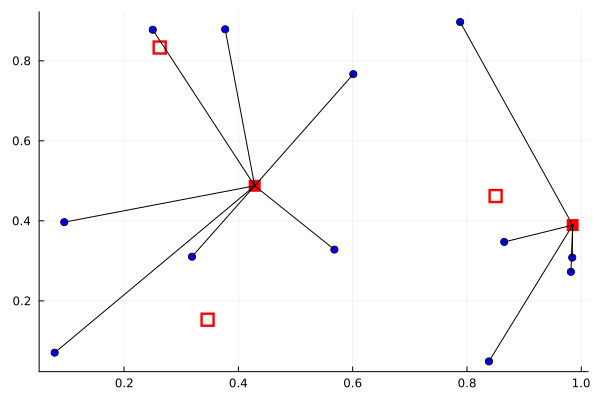

In [87]:
# see which were associated with which

#approximation tolerance
client_is_selected = isapprox.(value.(serve), 1; atol = 1e-5);
facility_is_selected = isapprox.(value.(fac_open), 1; atol = 1e-5);

#setting up the plot for the painting of facilities
p = Plots.scatter(cx, cy; markershape = :circle, markercolor = :blue, label = nothing)

#draw out: if facility is chosen or not
Plots.scatter!(fx, fy, markershape = :square, 
    markercolor = [(facility_is_selected[j] ? :red : :white) for j in 1:facilities], 
    markersize = 6, markerstrokecolor = :red, markerstrokewidth = 3, label = nothing)

#draw out: lines IF that particular one is chosen
for i in 1:clients, j in 1:facilities
    if client_is_selected[i, j]
        Plots.plot!([cx[i], fx[j]], [cy[i], fy[j]];
        color = :black, label = nothing)
    end
end

p

The tutorial covers the case of capacity-limited facilities, which isn't too relevant for now.

Tutorial at jump.dev/JuMP.jl/stable/tutorials/linear/facility_location

## MIP Dual Construction

I'm going to have to run the dual program of the UROP formulation, so this is important.

In [89]:
using JuMP
import HiGHS
# HiGHS: high-performance optimization; highs.dev

In [92]:
#=
using the new data structure: well it's not that new, similar to
the multidict which was presented in the Gurobi official simulations.
=#
generators = [
    (min = 0, max = 1000, fixed_cost = 1000, variable_cost = 50),
    (min = 300, max = 1000, fixed_cost = 0, variable_cost = 100)
]

N = length(generators) # going to be 2
print("Length of generators: ", N)

model = Model(HiGHS.Optimizer)

@variables(model, begin
    generators[i].min <= g[i = 1:N] <= generators[i].max
    0 <= w <= 200
    dispatch[i = 1:N], Bin
    end)
#=
I am not that familiar with generators, and the syntax is a bit new for me.
But let's see what we can do with it; the goal is to see the dual of a program.
=#

@constraints(model, begin
    power_balance, sum(g[i] for i in 1:N) + w == 1500
    [i = 1:N], g[i] <= generators[i].max * dispatch[i]
    [i = 1:N], g[i] >= generators[i].min * dispatch[i]
    end)

@objective(model, Min, sum(generators[i].fixed_cost * dispatch[i] +
        generators[i].variable_cost * g[i] for i in 1:N))

print(model)

Length of generators: 2

In [93]:
optimize!(model)

Running HiGHS 1.5.3 [date: 1970-01-01, git hash: 45a127b78]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
3 rows, 3 cols, 5 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve: Optimal

Solving report
  Status            Optimal
  Primal bound      81000
  Dual bound        81000
  Gap               0% (tolerance: 0.01%)
  Solution status   feasible
                    81000 (objective)
                    0 (bound viol.)
                    0 (int. viol.)
                    0 (row viol.)
  Timing            0.00 (total)
                    0.00 (presolve)
                    0.00 (postsolve)
  Nodes             0
  LP iterations     0 (total)
                    0 (strong br.)
                    0 (separation)
                    0 (heuristics)


In [94]:
# but somehow if we do dual status it tells us it's bad
dual_status(model)

NO_SOLUTION::ResultStatusCode = 0

In [95]:
#=
This issue was faced earlier as well when we did the Gurobi tutorial, and now
we can fix the problem in HiGHS by relaxation on integral values...

change it to LP and it can be solved
=#

discrete_values = value.(dispatch)
fix.(dispatch, discrete_values; force = true)
unset_binary.(dispatch)
print(model)

In [96]:
optimize!(model)

Presolving model
1 rows, 2 cols, 2 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve : Reductions: rows 0(-5); columns 0(-5); elements 0(-10) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  8.1000000000e+04
HiGHS run time      :          0.00


In [97]:
dual_status(model)

FEASIBLE_POINT::ResultStatusCode = 1

In [98]:
dual(power_balance)

100.0

In [99]:
# put it back to its original condition:
#=
unfix.(dispatch)
set_binary.(dispatch)
print(model)
=#

## Try Again with Original Furniture Example

Now that we know some of the ins and outs of the dual, we can try to get a feasible dual this time.

In [107]:
furniture = Model(Gurobi.Optimizer);

@variable(furniture, x1, base_name = "chairs") # chairs
@variable(furniture, x2, base_name = "tables") # tables

@objective(furniture, Max, 45*x1+80*x2)

@constraint(furniture, 5*x1+20*x2 <= 400, base_name = "wood_constraint")
@constraint(furniture, 10*x1 + 15*x2 <= 450, base_name = "labor_constraint")

#well these trivial constraints have to be set
@constraint(furniture, x1 >= 0, base_name = "non-negative chairs")
@constraint(furniture, x2 >= 0, base_name = "non-negative tables")


optimize!(furniture)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4 rows, 2 columns and 6 nonzeros
Model fingerprint: 0x73c67f7c
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [4e+01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+02, 4e+02]
Presolve removed 2 rows and 0 columns
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.6000000e+03   5.682900e+01   0.000000e+00      0s
       2    2.2000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.200000000e+03

User-callback calls 41, time in user-callback 0.00 sec


In [110]:
#try again
dual_status(furniture)

FEASIBLE_POINT::ResultStatusCode = 1

In [113]:
# extract shadow price
wood = constraint_by_name(furniture, "wood_constraint")
labor = constraint_by_name(furniture, "labor_constraint")

wood_shadow = shadow_price.(wood)

1.0

In [114]:
labor_shadow = shadow_price.(labor)

4.0

In [115]:
dual(wood)

-1.0

In [116]:
dual(labor)

-4.0

## These are all correct responses. Mission accomplished